# Recuperação do RA2
### Implementação de Sistemas Inteligentes Baseados em IA e IoT para Otimização da Previsibilidade de Atrasos em Linhas de Produção Automotivas: Uma Abordagem Focada no Provisionamento de Matéria-Prima e Manutenção Preditiva

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from IPython.display import display, HTML

## Analize inicial do dataset

In [2]:
# Carregamento DataFrame, baixado atraves do Link: https://www.kaggle.com/datasets/ziya07/intelligent-manufacturing-dataset e posteriormente salvo no GitHub: https://github.com/marcelowf/LineNex.Dataset/blob/main/dataset.csv
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset.csv'
df = pd.read_csv(url)
df.head(5)

,Timestamp,Machine_ID,Operation_Mode,Temperature_C,Vibration_Hz,Power_Consumption_kW,Network_Latency_ms,Packet_Loss_%,Quality_Control_Defect_Rate_%,Production_Speed_units_per_hr,Predictive_Maintenance_Score,Error_Rate_%,Efficiency_Status
0,2024-01-01 00:00:00,39,Idle,74.137590,3.500595,8.612162,10.650542,0.207764,7.751261,477.657391,0.344650,14.965470,Low
1,2024-01-01 00:01:00,29,Active,84.264558,3.355928,2.268559,29.111810,2.228464,4.989172,398.174747,0.769848,7.678270,Low
2,2024-01-01 00:02:00,15,Active,44.280102,2.079766,6.144105,18.357292,1.639416,0.456816,108.074959,0.987086,8.198391,Low
3,2024-01-01 00:03:00,43,Active,40.568502,0.298238,4.067825,29.153629,1.161021,4.582974,329.579410,0.983390,2.740847,Medium
4,2024-01-01 00:04:00,8,Idle,75.063817,0.345810,6.225737,34.029191,4.796520,2.287716,159.113525,0.573117,12.100686,Low


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Timestamp                      100000 non-null  object 
 1   Machine_ID                     100000 non-null  int64  
 2   Operation_Mode                 100000 non-null  object 
 3   Temperature_C                  100000 non-null  float64
 4   Vibration_Hz                   100000 non-null  float64
 5   Power_Consumption_kW           100000 non-null  float64
 6   Network_Latency_ms             100000 non-null  float64
 7   Packet_Loss_%                  100000 non-null  float64
 8   Quality_Control_Defect_Rate_%  100000 non-null  float64
 9   Production_Speed_units_per_hr  100000 non-null  float64
 10  Predictive_Maintenance_Score   100000 non-null  float64
 11  Error_Rate_%                   100000 non-null  float64
 12  Efficiency_Status              

In [4]:
df.shape

(100000, 13)

In [5]:
df.describe()

,Machine_ID,Temperature_C,Vibration_Hz,Power_Consumption_kW,Network_Latency_ms,Packet_Loss_%,Quality_Control_Defect_Rate_%,Production_Speed_units_per_hr,Predictive_Maintenance_Score,Error_Rate_%
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,25.499330,60.041458,2.549959,5.745929,25.555620,2.493418,5.008806,275.916324,0.499385,7.504100
std,14.389439,17.323238,1.414127,2.451271,14.120758,1.443273,2.883666,130.096892,0.288814,4.335896
min,1.000000,30.000138,0.100011,1.500183,1.000025,0.000026,0.000449,50.000375,0.000003,0.000112
25%,13.000000,45.031596,1.323214,3.627318,13.355118,1.245026,2.521591,162.873618,0.248166,3.750148
50%,25.000000,60.033597,2.549441,5.755460,25.536079,2.487667,5.003569,276.648922,0.499209,7.504145
75%,38.000000,74.967217,3.776459,7.860267,37.796372,3.741252,7.506127,388.812761,0.748810,11.273189
max,50.000000,89.998979,4.999974,9.999889,49.999917,4.999975,9.999900,499.996768,0.999978,14.999869


In [6]:
print("Operation_Mode:", df['Operation_Mode'].unique())
print("Efficiency_Status:", df['Efficiency_Status'].unique())

Operation_Mode: ['Idle' 'Active' 'Maintenance']
Efficiency_Status: ['Low' 'Medium' 'High']


In [7]:
df['Operation_Mode'].value_counts()

,count
Operation_Mode,
Active,70054
Idle,20057
Maintenance,9889


In [8]:
df['Efficiency_Status'].value_counts()

,count
Efficiency_Status,
Low,77825
Medium,19189
High,2986


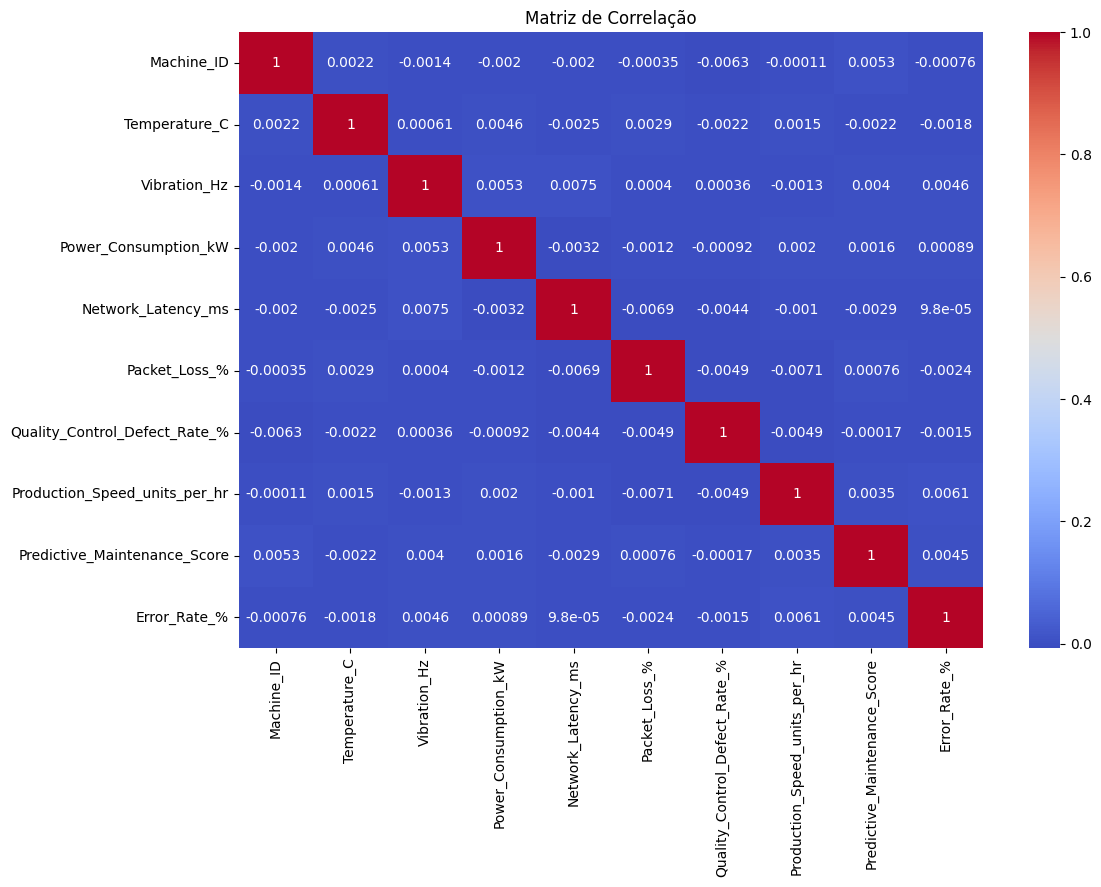

In [9]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

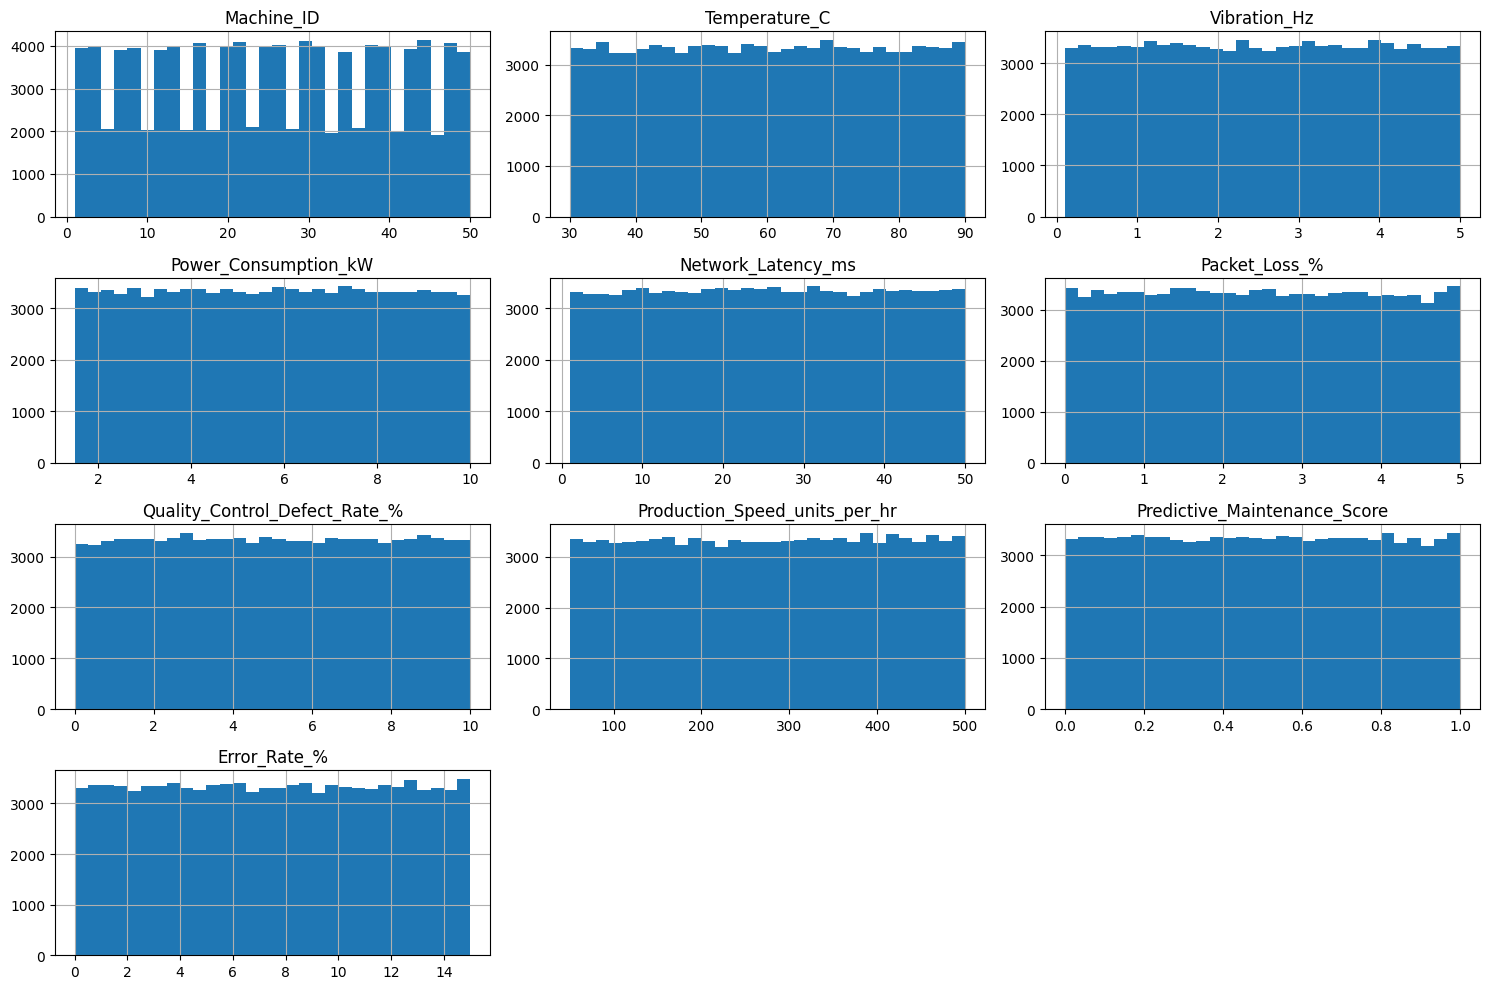

In [10]:
df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

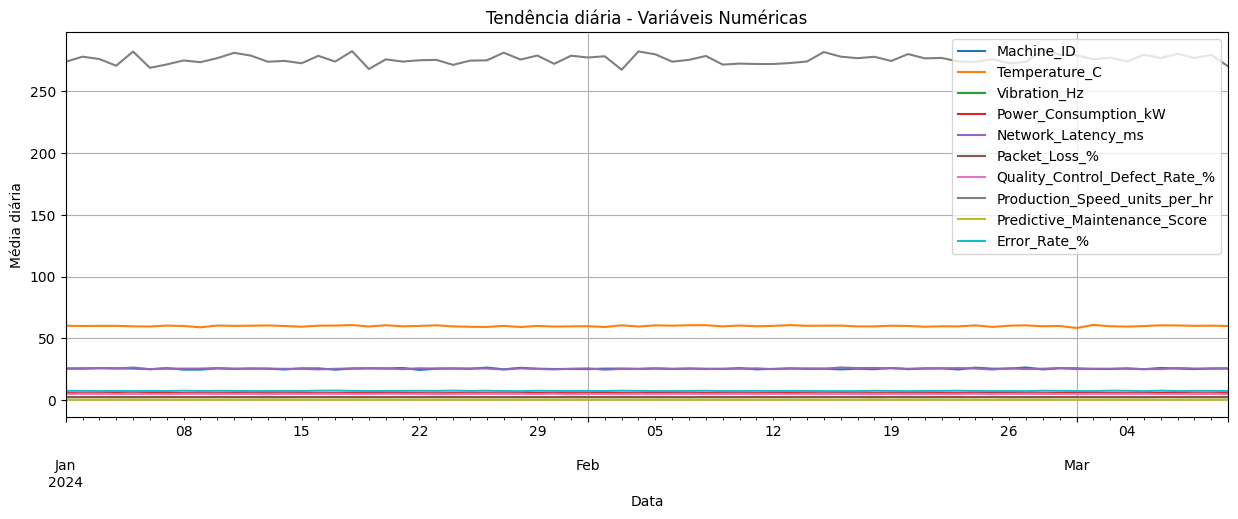

In [11]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df.set_index('Timestamp', inplace=True)
df_numeric = df.select_dtypes(include='number')
df_numeric.resample('D').mean().plot(figsize=(15, 5))

plt.title("Tendência diária - Variáveis Numéricas")
plt.xlabel("Data")
plt.ylabel("Média diária")
plt.grid(True)
plt.show()

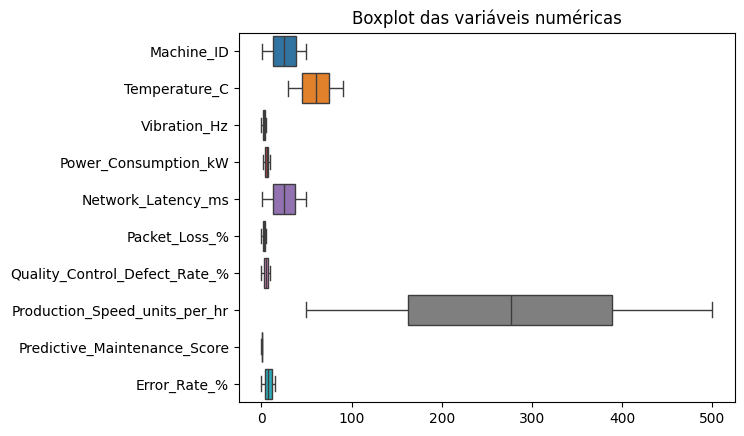

In [12]:
sns.boxplot(data=df.select_dtypes(include='number'), orient='h')
plt.title("Boxplot das variáveis numéricas")
plt.show()

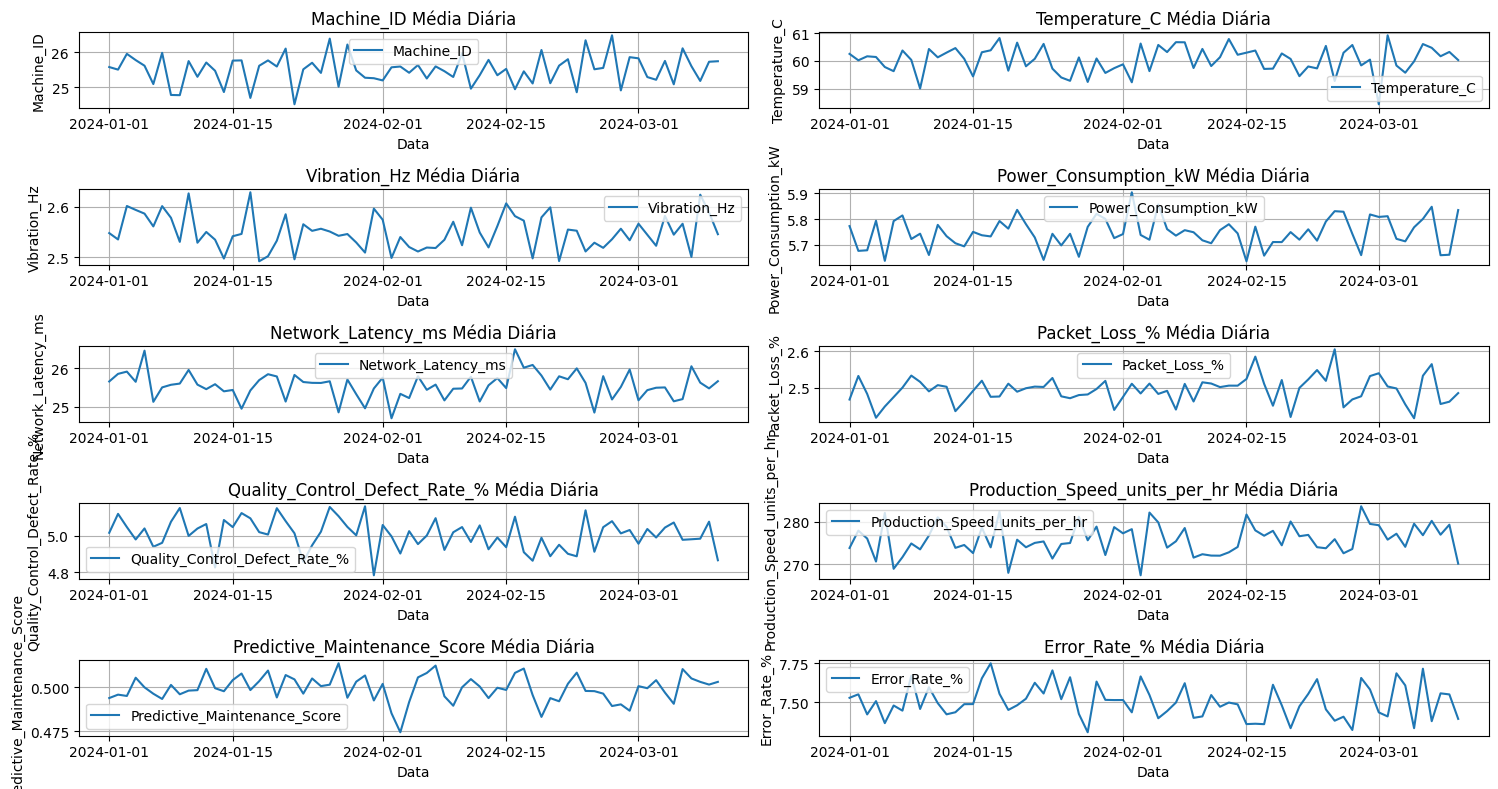

In [13]:
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset.csv'
df = pd.read_csv(url)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

df_daily = df[numeric_cols].resample('D').mean()

plt.figure(figsize=(15, 8))
num_cols_to_plot = len(numeric_cols)
rows = (num_cols_to_plot + 1) // 2
cols = 2
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)
    plt.plot(df_daily.index, df_daily[col], label=col)
    plt.title(f'{col} Média Diária')
    plt.xlabel('Data')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

## Criação de visualizações pós analize inicial para o artigo

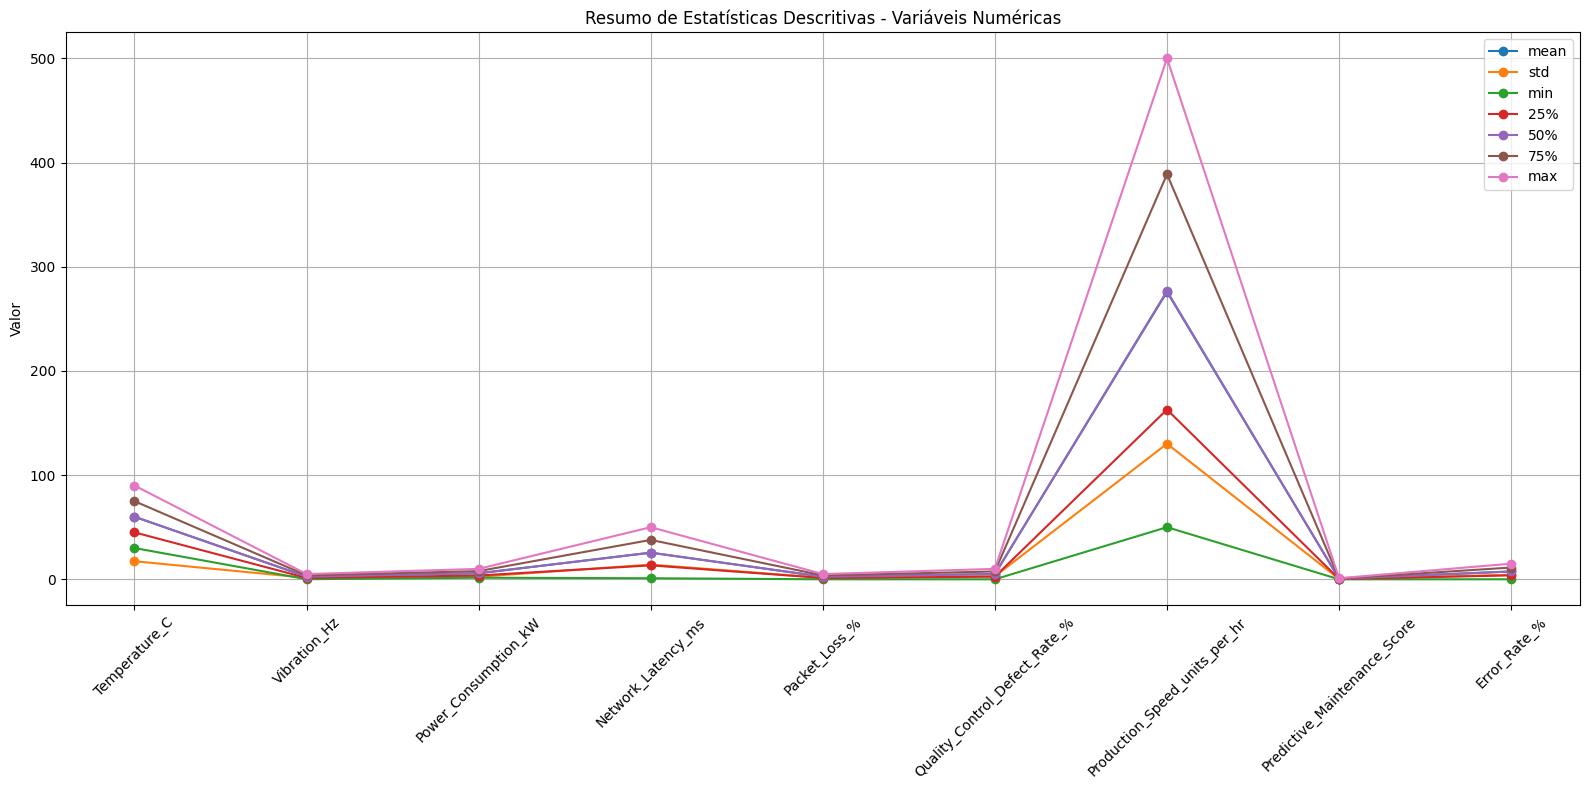

In [14]:
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset.csv'
df = pd.read_csv(url)

if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)

df_numeric = df.select_dtypes(include=['float64', 'int64'])

if 'Machine_ID' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['Machine_ID'])

desc_stats = df_numeric.describe().T
stats_to_plot = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

plt.figure(figsize=(16, 8))
for stat in stats_to_plot:
    plt.plot(desc_stats.index, desc_stats[stat], marker='o', label=stat)

plt.title("Resumo de Estatísticas Descritivas - Variáveis Numéricas")
plt.xticks(rotation=45)
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

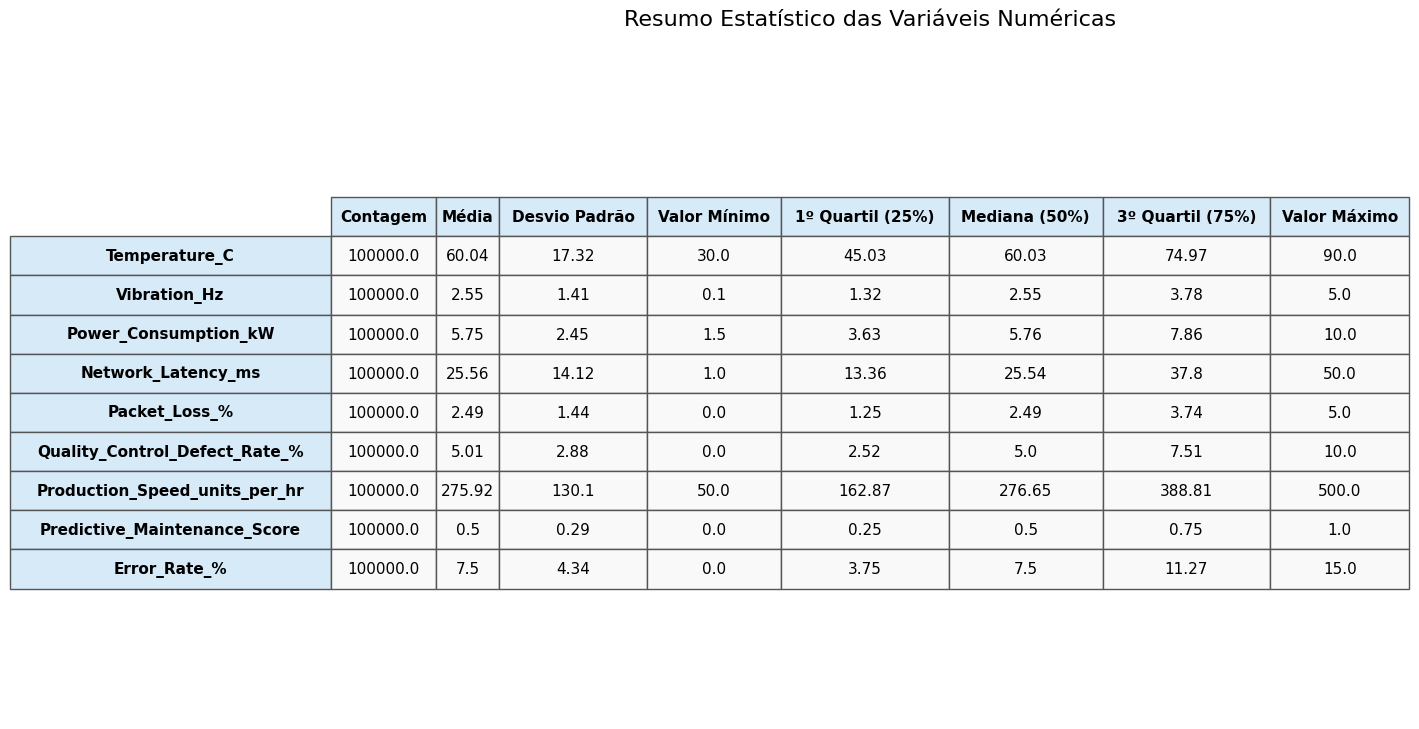

In [15]:
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset.csv'
df = pd.read_csv(url)

if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)

df_numeric = df.select_dtypes(include=['float64', 'int64'])
if 'Machine_ID' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['Machine_ID'])

desc_stats = df_numeric.describe().T.round(2)

novo_nome_colunas = {
    'count': 'Contagem',
    'mean': 'Média',
    'std': 'Desvio Padrão',
    'min': 'Valor Mínimo',
    '25%': '1º Quartil (25%)',
    '50%': 'Mediana (50%)',
    '75%': '3º Quartil (75%)',
    'max': 'Valor Máximo'
}

desc_stats.rename(columns=novo_nome_colunas, inplace=True)

fig, ax = plt.subplots(figsize=(14, len(desc_stats)*0.6 + 2))
ax.axis('off')

table = ax.table(
    cellText=desc_stats.values,
    rowLabels=desc_stats.index,
    colLabels=desc_stats.columns,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.auto_set_column_width(col=list(range(len(desc_stats.columns))))

for key, cell in table.get_celld().items():
    cell.set_height(0.06)
    cell.set_edgecolor('#555555')

    if key[0] == 0 or key[1] == -1:
        cell.set_facecolor('#D6EAF8')
        cell.set_text_props(weight='bold')
    else:
        cell.set_facecolor('#F9F9F9')

plt.title('Resumo Estatístico das Variáveis Numéricas', fontsize=16, pad=30)

plt.tight_layout()
plt.show()

/tmp/ipython-input-17-1077669888.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(counts_op.index, rotation=45, ha='right')
/tmp/ipython-input-17-1077669888.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(counts_eff.index, rotation=45, ha='right')


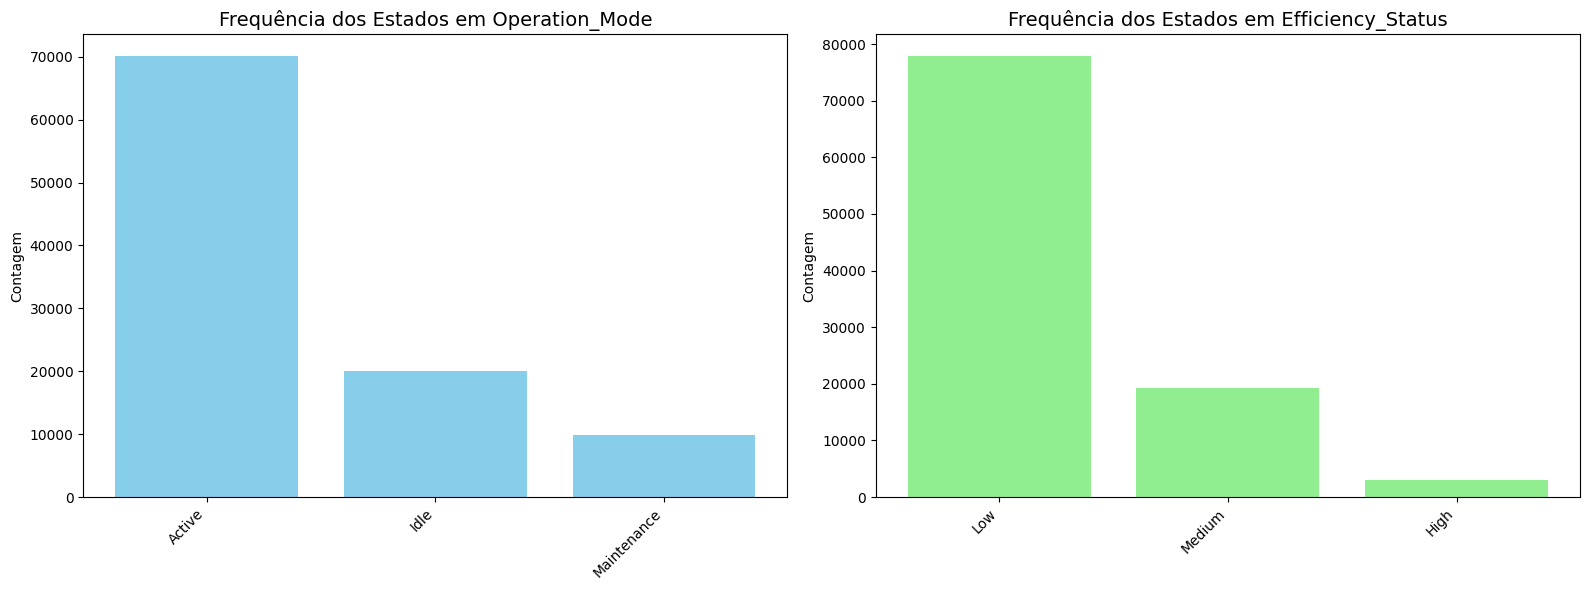

In [17]:
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset.csv'
df = pd.read_csv(url)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

counts_op = df['Operation_Mode'].value_counts()
axes[0].bar(counts_op.index, counts_op.values, color='skyblue')
axes[0].set_title('Frequência dos Estados em Operation_Mode', fontsize=14)
axes[0].set_ylabel('Contagem')
axes[0].set_xticklabels(counts_op.index, rotation=45, ha='right')

counts_eff = df['Efficiency_Status'].value_counts()
axes[1].bar(counts_eff.index, counts_eff.values, color='lightgreen')
axes[1].set_title('Frequência dos Estados em Efficiency_Status', fontsize=14)
axes[1].set_ylabel('Contagem')
axes[1].set_xticklabels(counts_eff.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [18]:
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset.csv'
df = pd.read_csv(url)

nomes_portugues = {
    'Timestamp': 'Data/Hora',
    'Machine_ID': 'ID da Máquina',
    'Operation_Mode': 'Modo de Operação',
    'Temperature_C': 'Temperatura (°C)',
    'Vibration_Hz': 'Vibração (Hz)',
    'Power_Consumption_kW': 'Consumo de Energia (kW)',
    'Network_Latency_ms': 'Latência da Rede (ms)',
    'Packet_Loss_%': 'Perda de Pacotes (%)',
    'Quality_Control_Defect_Rate_%': 'Taxa de Defeitos no Controle de Qualidade (%)',
    'Production_Speed_units_per_hr': 'Velocidade de Produção (unidades/hora)',
    'Predictive_Maintenance_Score': 'Índice de Manutenção Preditiva',
    'Error_Rate_%': 'Taxa de Erro (%)',
    'Efficiency_Status': 'Status de Eficiência'
}

data_description = pd.DataFrame({
    'Coluna': [nomes_portugues.get(col, col) for col in df.columns],
    'Não Nulos': df.notnull().sum(),
    'Descrição': [
        "Timestamp da medição",
        "Identificador da máquina",
        "Modo de operação da máquina",
        "Temperatura em Celsius",
        "Vibração em Hertz",
        "Consumo de energia em kW",
        "Latência da rede em ms",
        "Perda de pacotes na rede (%)",
        "Taxa de defeitos no controle de qualidade (%)",
        "Velocidade de produção (unidades/hora)",
        "Pontuação de manutenção preditiva",
        "Taxa de erros (%)",
        "Status de eficiência da produção"
    ]
})

styled_table = data_description.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                 ('color', '#333333'),
                                 ('font-size', '10pt'),
                                 ('font-family', 'Arial, sans-serif')]},
    {'selector': 'td', 'props': [('font-size', '9pt'),
                                 ('font-family', 'Arial, sans-serif')]},
    {'selector': 'th, td', 'props': [('padding', '8px')]}
]).set_properties(**{'text-align': 'left'})

display(HTML(styled_table.to_html(index=False)))

,Coluna,Não Nulos,Descrição
Timestamp,Data/Hora,100000,Timestamp da medição
Machine_ID,ID da Máquina,100000,Identificador da máquina
Operation_Mode,Modo de Operação,100000,Modo de operação da máquina
Temperature_C,Temperatura (°C),100000,Temperatura em Celsius
Vibration_Hz,Vibração (Hz),100000,Vibração em Hertz
Power_Consumption_kW,Consumo de Energia (kW),100000,Consumo de energia em kW
Network_Latency_ms,Latência da Rede (ms),100000,Latência da rede em ms
Packet_Loss_%,Perda de Pacotes (%),100000,Perda de pacotes na rede (%)
Quality_Control_Defect_Rate_%,Taxa de Defeitos no Controle de Qualidade (%),100000,Taxa de defeitos no controle de qualidade (%)
Production_Speed_units_per_hr,Velocidade de Produção (unidades/hora),100000,Velocidade de produção (unidades/hora)


## Tratamento do dataset

In [60]:
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset.csv'
df = pd.read_csv(url)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.sort_values(by='Timestamp', inplace=True)

df['Operation_Mode'] = LabelEncoder().fit_transform(df['Operation_Mode'])
df['Efficiency_Status'] = LabelEncoder().fit_transform(df['Efficiency_Status'])

df.to_csv('dataset_preprocessado.csv', index=False)

In [61]:
df = pd.read_csv('dataset_preprocessado.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

In [62]:
machine_id = df[['Machine_ID']]
features_to_scale = df.drop(columns=['Machine_ID'])

scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_to_scale),
                               columns=features_to_scale.columns,
                               index=features_to_scale.index)

df_normalizado = pd.concat([machine_id, features_scaled], axis=1)

In [63]:
df_normalizado.to_csv('dataset_normalizado.csv')

## Criação de visualizações pós tratamento para o artigo

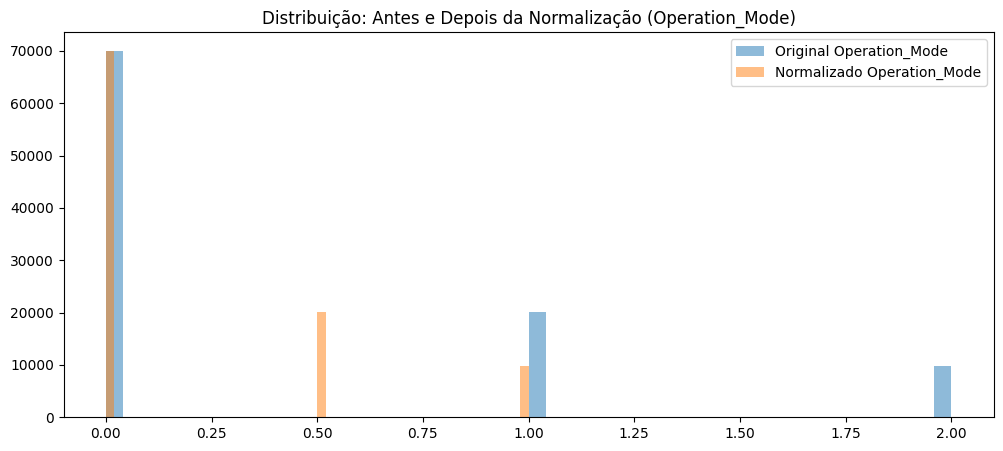

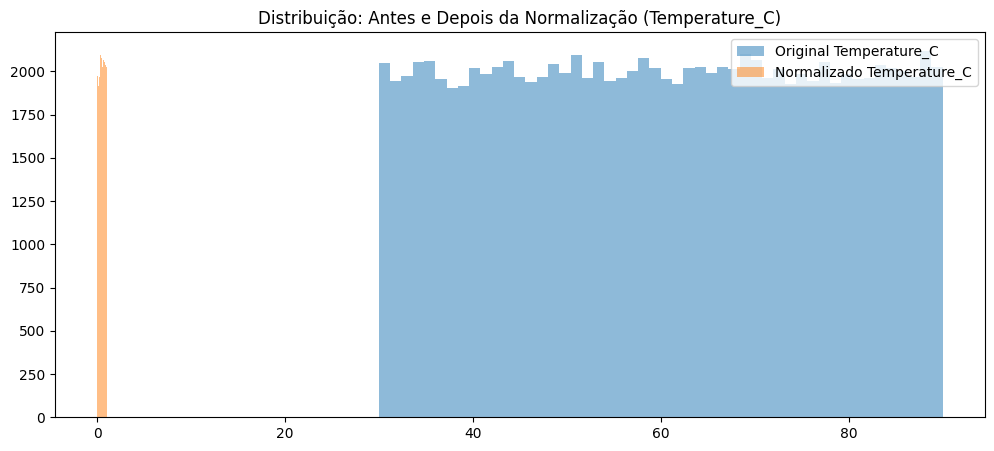

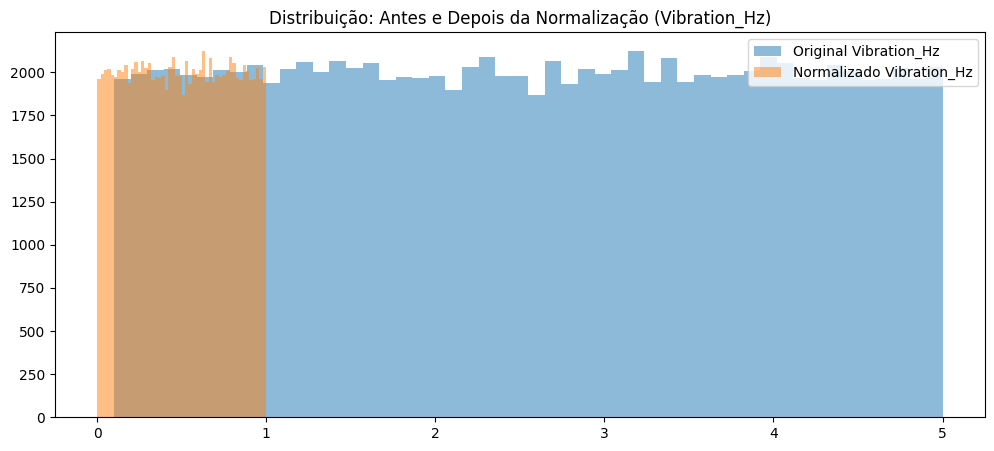

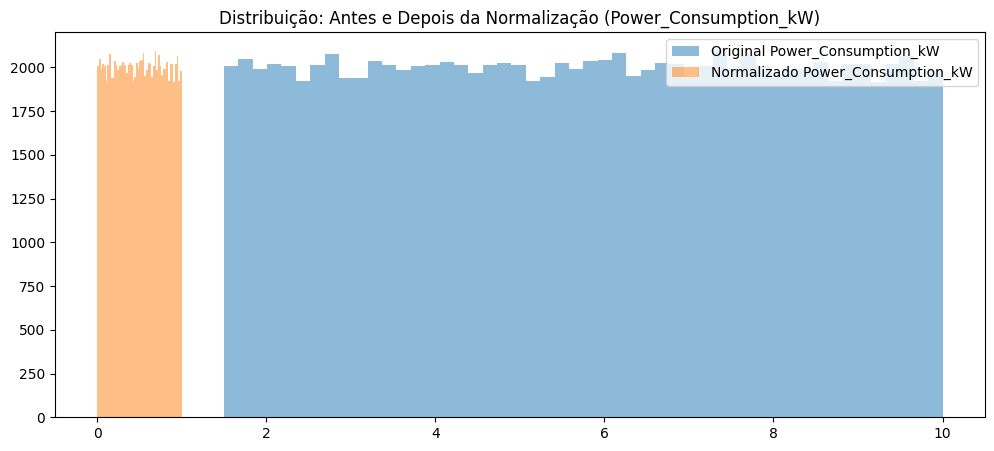

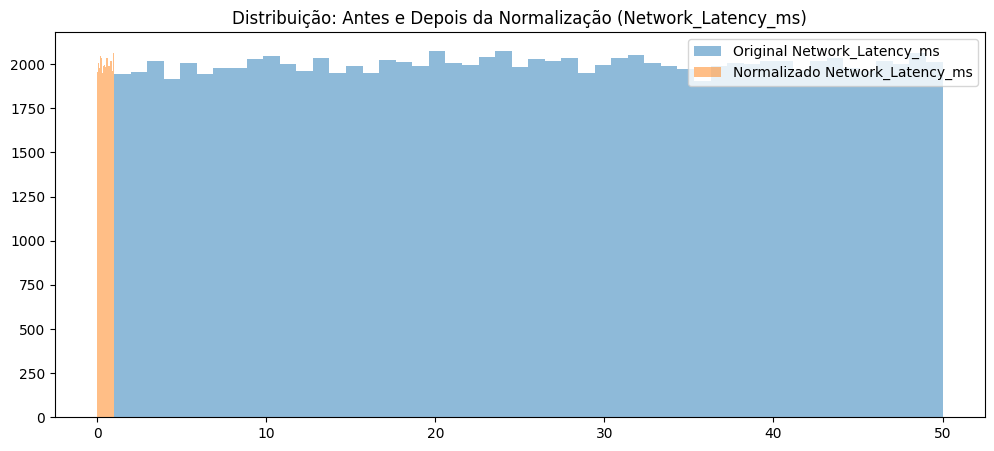

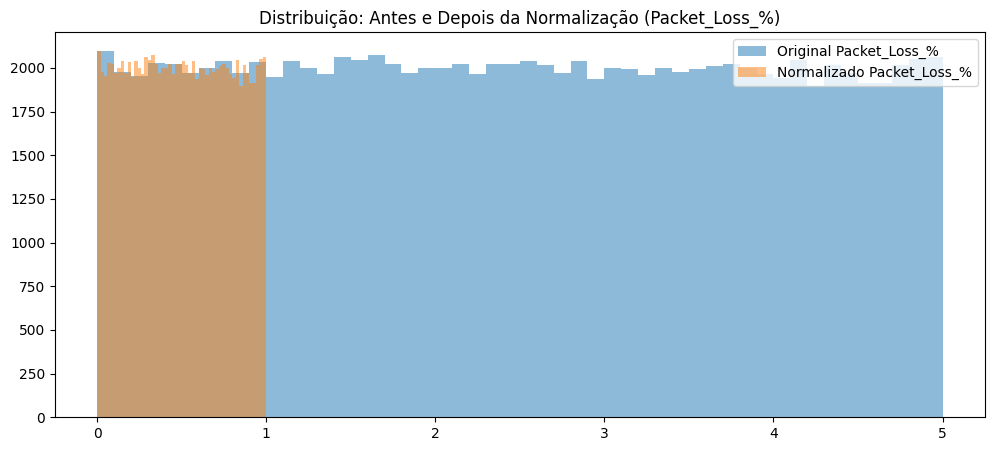

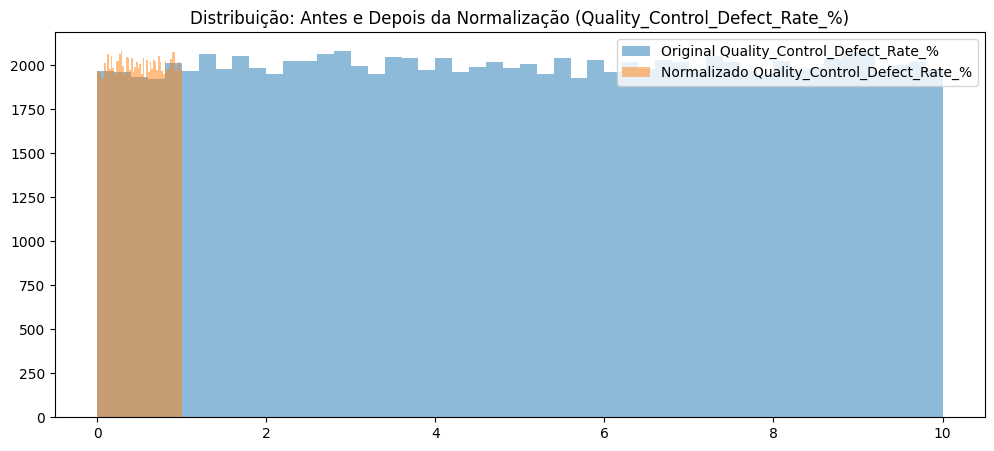

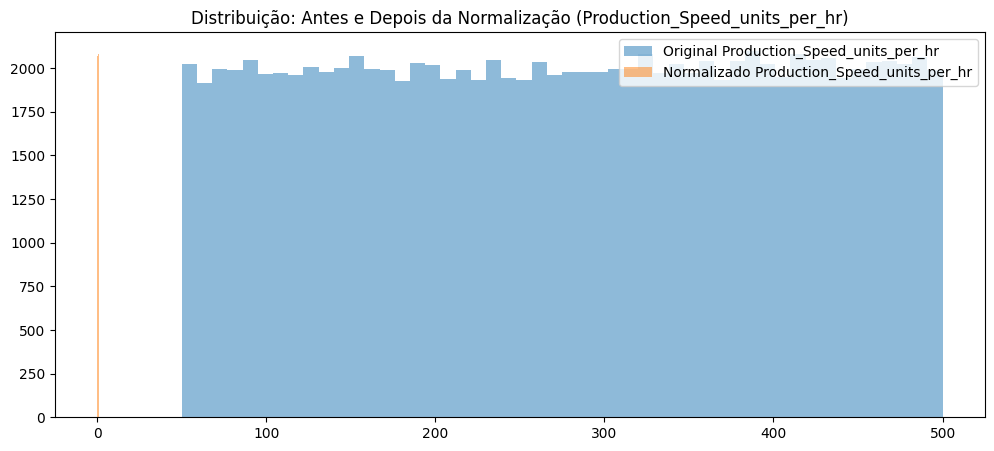

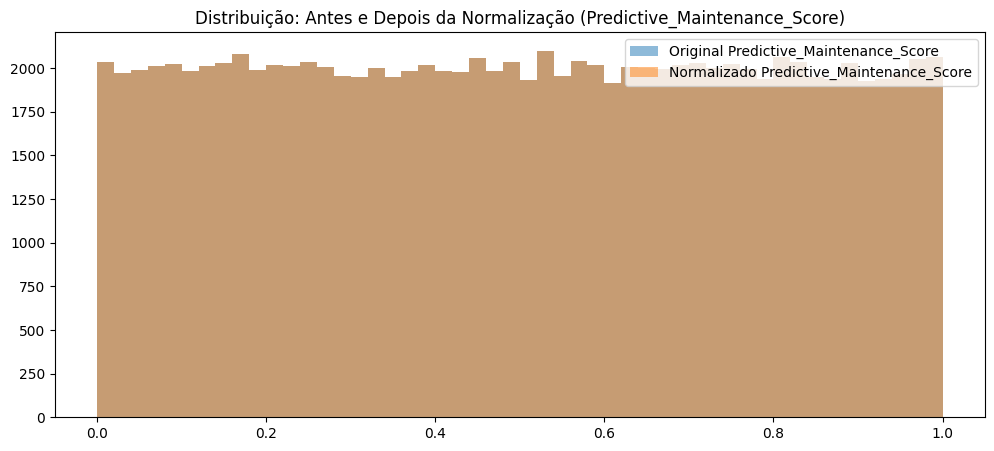

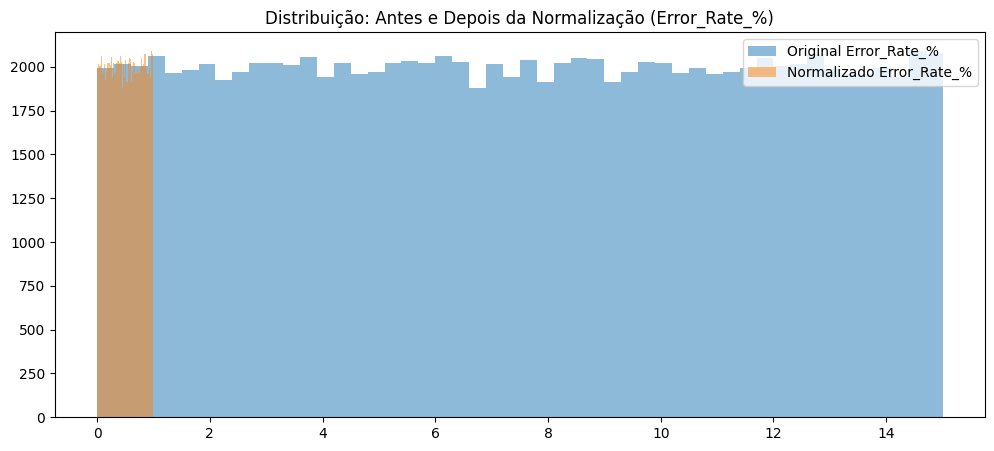

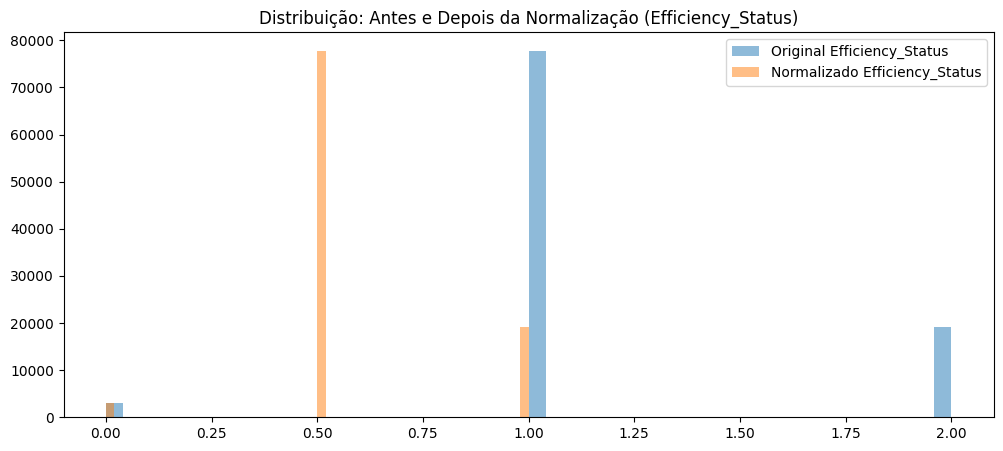

In [66]:
for col in features_scaled.columns:
    plt.figure(figsize=(12, 5))
    plt.hist(df[col], bins=50, alpha=0.5, label=f'Original {col}')
    plt.hist(features_scaled[col], bins=50, alpha=0.5, label=f'Normalizado {col}')
    plt.legend()
    plt.title(f'Distribuição: Antes e Depois da Normalização ({col})')
    plt.show()

## Escolhendo variavel alvo para Arima e Sarima

In [167]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Carregar e preparar dados
url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/dataset_preprocessado.csv'
df = pd.read_csv(url, parse_dates=['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Variáveis candidatas
candidate_vars = [
    'Production_Speed_units_per_hr',
    'Predictive_Maintenance_Score',
    'Efficiency_Status',
    'Quality_Control_Defect_Rate_%',
    'Error_Rate_%'
]

# Parâmetros para grid ARIMA (p, d, q)
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

# Resultado final
results = []

# Loop por máquina
for machine_id in tqdm(df['Machine_ID'].unique(), desc="Máquinas"):
    df_machine = df[df['Machine_ID'] == machine_id]

    for var in candidate_vars:
        series = df_machine[var].dropna()

        if len(series) < 50:
            continue  # pula se a série for muito curta

        best_aic = np.inf
        best_order = None
        best_model = None
        best_mse = None

        # Testar várias combinações
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = ARIMA(series, order=(p, d, q)).fit()
                        aic = model.aic
                        if aic < best_aic:
                            best_aic = aic
                            best_order = (p, d, q)
                            best_model = model
                            mse = mean_squared_error(series[d:], model.predict())
                            best_mse = mse
                    except:
                        continue  # ignora erros em ajustes inválidos

        if best_model is not None:
            results.append({
                'Machine_ID': machine_id,
                'Variable': var,
                'ARIMA_Order': f"{best_order}",
                'AIC': best_model.aic,
                'BIC': best_model.bic,
                'MSE': best_mse,
                'p': best_order[0],
                'd': best_order[1],
                'q': best_order[2],
                'n_obs': len(series)
            })

# Salvar CSV
results_df = pd.DataFrame(results)
results_df.to_csv('melhores_modelos_arima_por_maquina.csv', index=False)
print("CSV gerado com sucesso!")


Máquinas: 100%|██████████| 50/50 [5:43:55<00:00, 412.70s/it]

CSV gerado com sucesso!


## Treinamento

Os treinamentos foram feitos em dois Jupternotebooks separados, segue os links:

Arima e Sarima: https://colab.research.google.com/drive/16GJtH-XE0zlfjR3MmwwHqz8NSpvfqIdp?usp=sharing

Lstm, Gru e Tcn: https://colab.research.google.com/drive/1VqfhF8bbBajuSza6AiYNXz0aYktusXQE?usp=sharing

## Avaliação dos resultados

### LSTM, GRU, TCN

In [28]:
df_url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/todos_modelos_avaliados_lstm_gru_tcn.csv'
df_all = pd.read_csv(df_url)

# resumo médio das métricas por Modelo e Janelamento
summary_avg = df_all.groupby(['Window', 'Model'])[['RMSE', 'MAE', 'MAPE', 'SMAPE', 'WAPE', 'R2']].mean().reset_index()
print("\nMédia das métricas por Modelo e Janelamento:")
print(summary_avg)


Média das métricas por Modelo e Janelamento:
   Window Model      RMSE       MAE          MAPE      SMAPE       WAPE  \
0      20   GRU  0.291727  0.252828  1.124047e+11  57.748374  50.083369   
1      20  LSTM  0.291125  0.252706  1.184138e+11  57.706184  50.058801   
2      20   TCN  0.324996  0.272552  1.323925e+11  61.920353  54.001049   
3      40   GRU  0.291855  0.252920  1.162974e+11  57.782171  50.117418   
4      40  LSTM  0.290880  0.252526  1.229182e+11  57.685416  50.039641   
5      40   TCN  0.328239  0.274845  1.416612e+11  62.321472  54.463711   
6      60   GRU  0.291949  0.253131  1.206125e+11  57.822640  50.145473   
7      60  LSTM  0.291193  0.252849  1.198424e+11  57.732255  50.088859   
8      60   TCN  0.333354  0.278598  8.172312e+10  63.277705  55.176021   

         R2  
0 -0.009655  
1 -0.005471  
2 -0.256333  
3 -0.011078  
4 -0.004349  
5 -0.282636  
6 -0.011111  
7 -0.005812  
8 -0.323012  


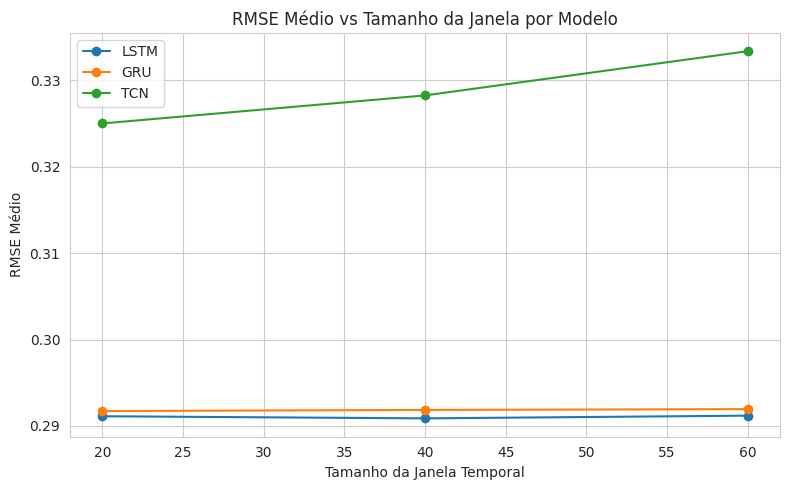

In [29]:
# linha de tendência RMSE médio por modelo e janela
plt.figure(figsize=(8, 5))
for model in df_all['Model'].unique():
    df_plot = summary_avg[summary_avg['Model'] == model]
    plt.plot(df_plot['Window'], df_plot['RMSE'], marker='o', label=model)
plt.title('RMSE Médio vs Tamanho da Janela por Modelo')
plt.xlabel('Tamanho da Janela Temporal')
plt.ylabel('RMSE Médio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-1075387371.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_all['Model'].unique())


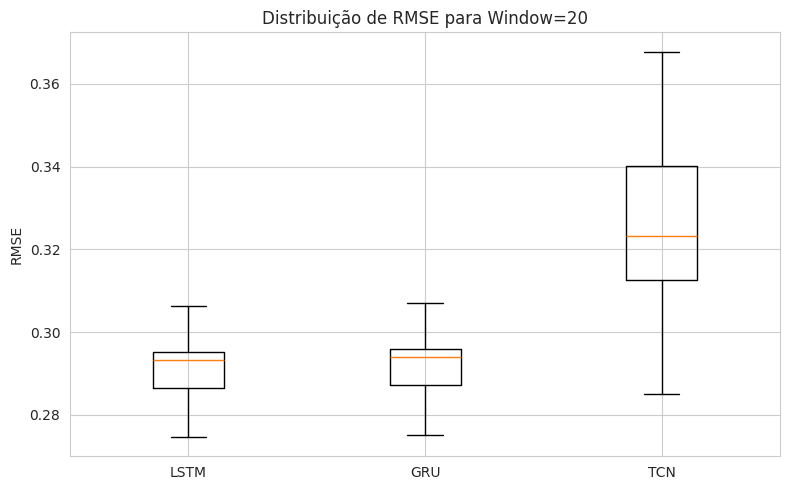

/tmp/ipython-input-30-1075387371.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_all['Model'].unique())


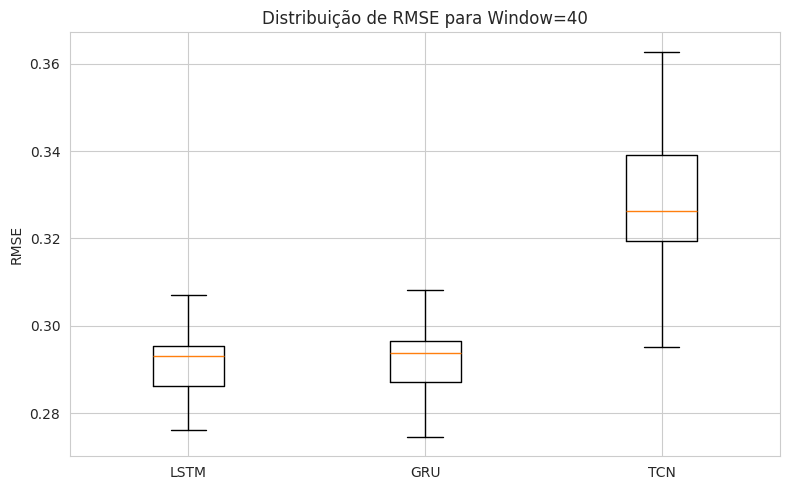

/tmp/ipython-input-30-1075387371.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_all['Model'].unique())


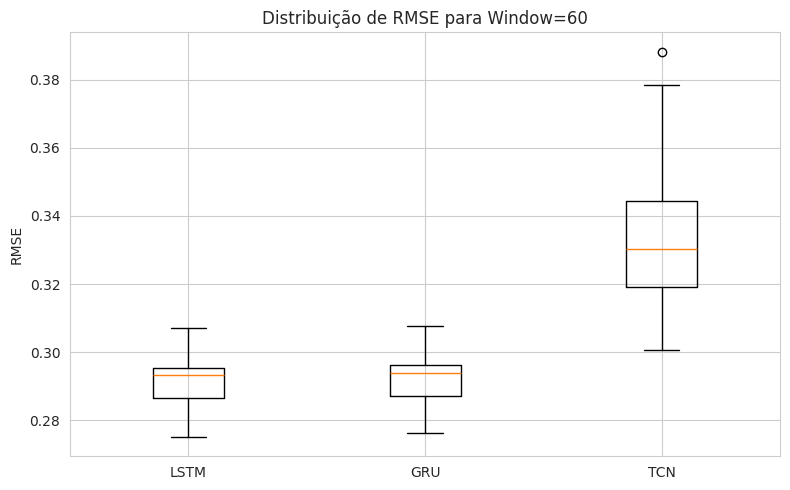

In [30]:
# boxplot RMSE por modelo e janela
for window in sorted(df_all['Window'].unique()):
    plt.figure(figsize=(8, 5))
    data = [df_all[(df_all['Window'] == window) & (df_all['Model'] == m)]['RMSE'] for m in df_all['Model'].unique()]
    plt.boxplot(data, labels=df_all['Model'].unique())
    plt.title(f'Distribuição de RMSE para Window={window}')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Contagem de Melhores Modelos por Janela (menor RMSE):
  Model  Count  Window
0  LSTM     35      20
1   GRU     15      20
2  LSTM     39      40
3   GRU     11      40
4  LSTM     34      60
5   GRU     16      60


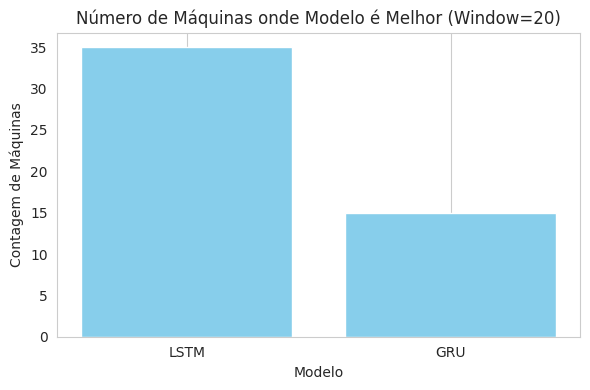

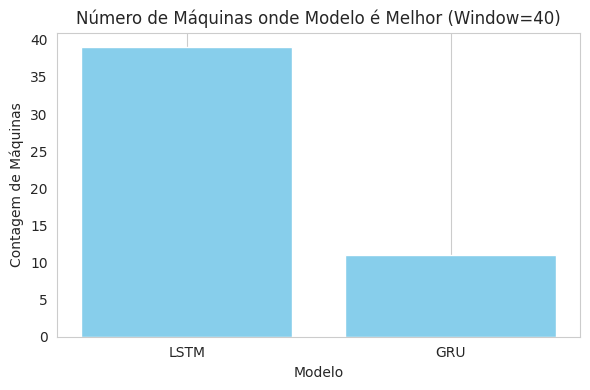

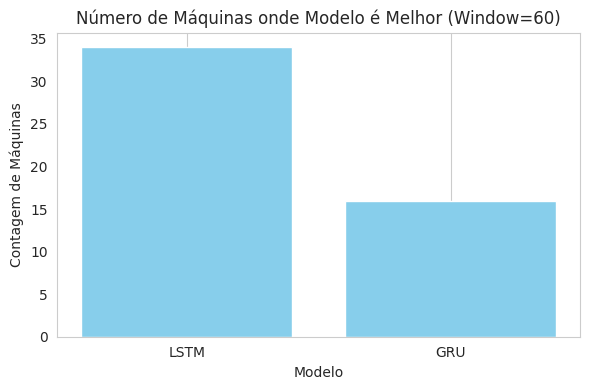

In [31]:
# contagem de melhores modelos por máquina usando RMSE
best_counts = []
for window in sorted(df_all['Window'].unique()):
    df_w = df_all[df_all['Window'] == window]
    best_per_machine = df_w.loc[df_w.groupby('Machine_ID')['RMSE'].idxmin()]
    counts = best_per_machine['Model'].value_counts().reset_index()
    counts.columns = ['Model', 'Count']
    counts['Window'] = window
    best_counts.append(counts)

best_counts_df = pd.concat(best_counts, ignore_index=True)
print("\nContagem de Melhores Modelos por Janela (menor RMSE):")
print(best_counts_df)

for window in sorted(df_all['Window'].unique()):
    df_plot = best_counts_df[best_counts_df['Window'] == window]
    plt.figure(figsize=(6, 4))
    plt.bar(df_plot['Model'], df_plot['Count'], color='skyblue')
    plt.title(f'Número de Máquinas onde Modelo é Melhor (Window={window})')
    plt.xlabel('Modelo')
    plt.ylabel('Contagem de Máquinas')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

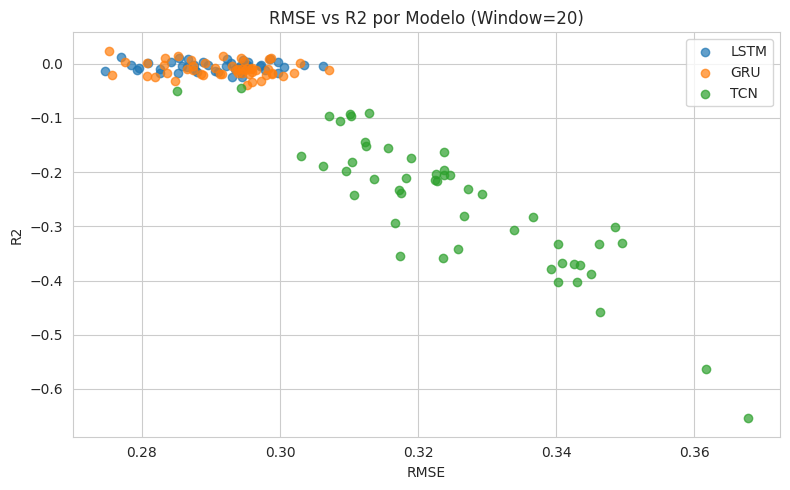

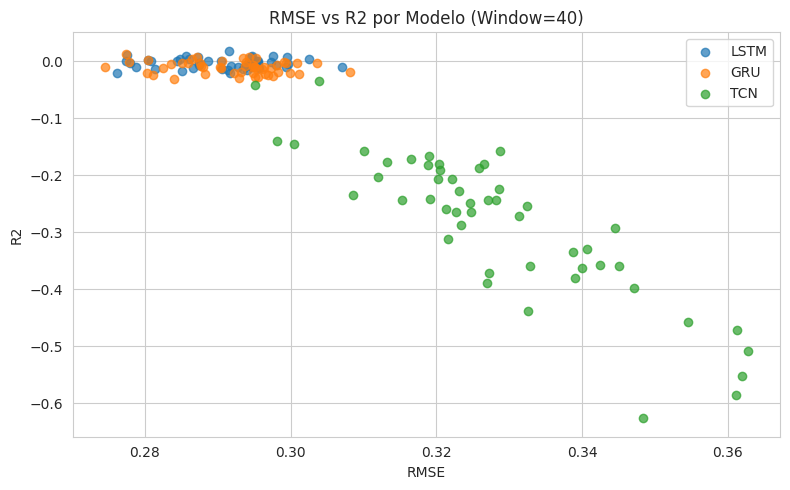

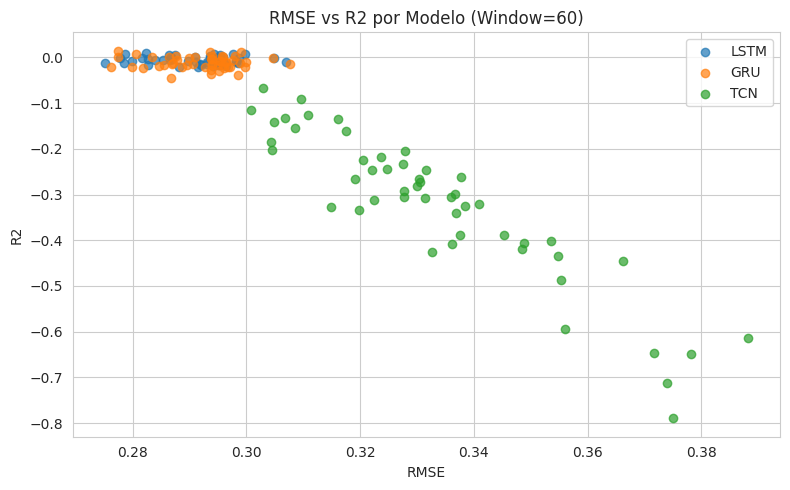

In [32]:
# scatter RMSE vs R2 por modelo e janela
for window in sorted(df_all['Window'].unique()):
    plt.figure(figsize=(8, 5))
    df_w = df_all[df_all['Window'] == window]
    for model in df_w['Model'].unique():
        subset = df_w[df_w['Model'] == model]
        plt.scatter(subset['RMSE'], subset['R2'], label=model, alpha=0.7)
    plt.title(f'RMSE vs R2 por Modelo (Window={window})')
    plt.xlabel('RMSE')
    plt.ylabel('R2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Mediana do MAE de Validação por Modelo e Janelamento:
   Window Model   val_mae
0      20   GRU  0.255761
1      20  LSTM  0.254581
2      20   TCN  0.285921
3      40   GRU  0.254524
4      40  LSTM  0.254391
5      40   TCN  0.289009
6      60   GRU  0.254834
7      60  LSTM  0.254919
8      60   TCN  0.288209


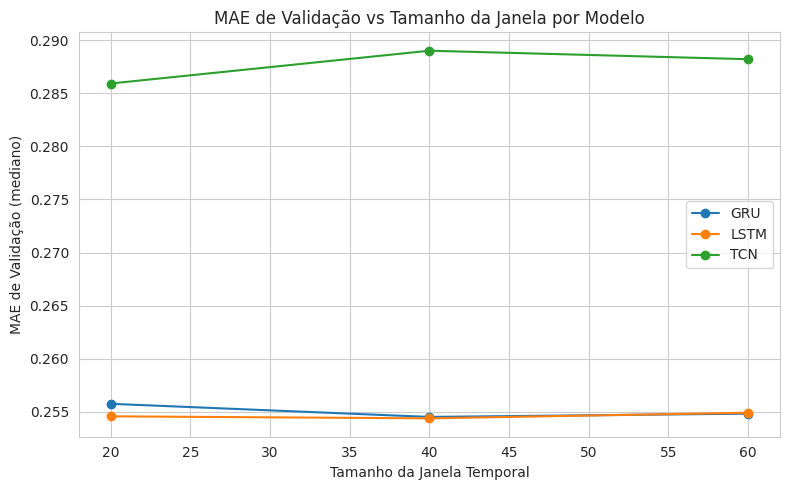

In [33]:
# evolução do MAE de validação por modelo e janela
summary_mae = df_all.groupby(['Window', 'Model'])['val_mae'].median().reset_index()
print("\nMediana do MAE de Validação por Modelo e Janelamento:")
print(summary_mae)

plt.figure(figsize=(8, 5))
for model in summary_mae['Model'].unique():
    df_plot = summary_mae[summary_mae['Model'] == model]
    plt.plot(df_plot['Window'], df_plot['val_mae'], marker='o', label=model)
plt.title('MAE de Validação vs Tamanho da Janela por Modelo')
plt.xlabel('Tamanho da Janela Temporal')
plt.ylabel('MAE de Validação (mediano)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-34-3073129046.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_all['Model'].unique())


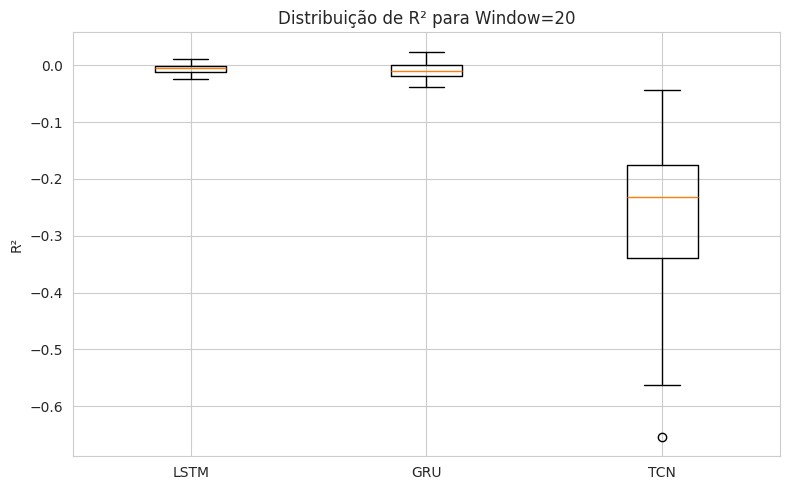

/tmp/ipython-input-34-3073129046.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_all['Model'].unique())


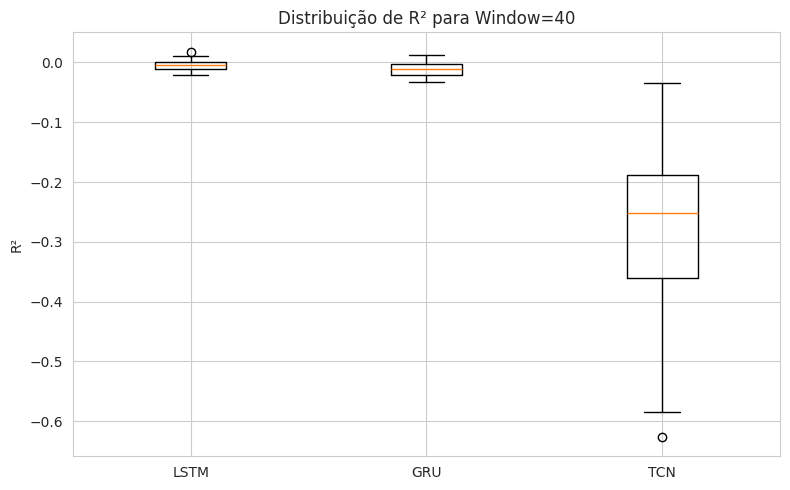

/tmp/ipython-input-34-3073129046.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_all['Model'].unique())


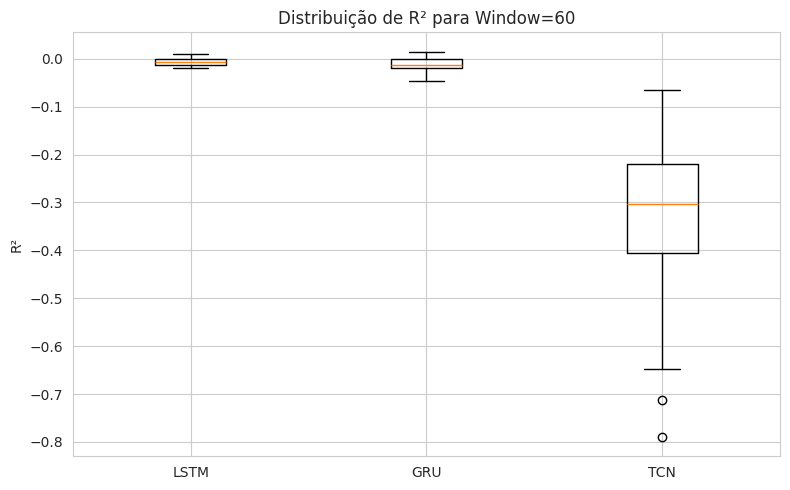

In [34]:
# boxplot R² por modelo e janela
for window in sorted(df_all['Window'].unique()):
    plt.figure(figsize=(8, 5))
    data = [df_all[(df_all['Window'] == window) & (df_all['Model'] == m)]['R2'] for m in df_all['Model'].unique()]
    plt.boxplot(data, labels=df_all['Model'].unique())
    plt.title(f'Distribuição de R² para Window={window}')
    plt.ylabel('R²')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

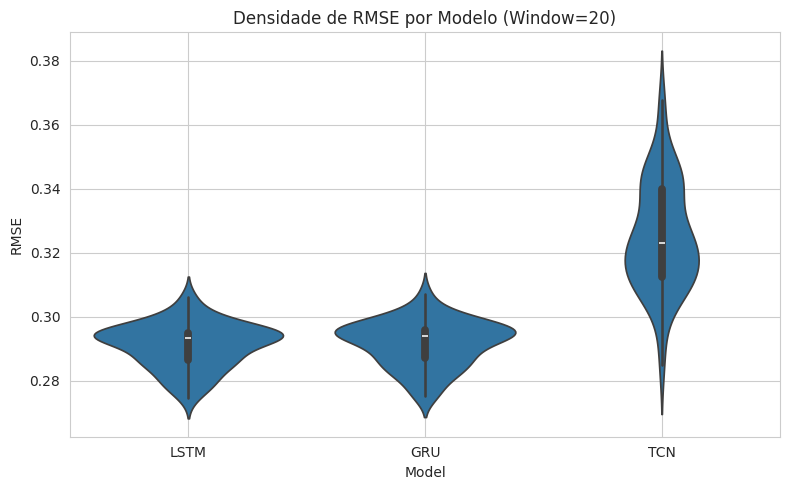

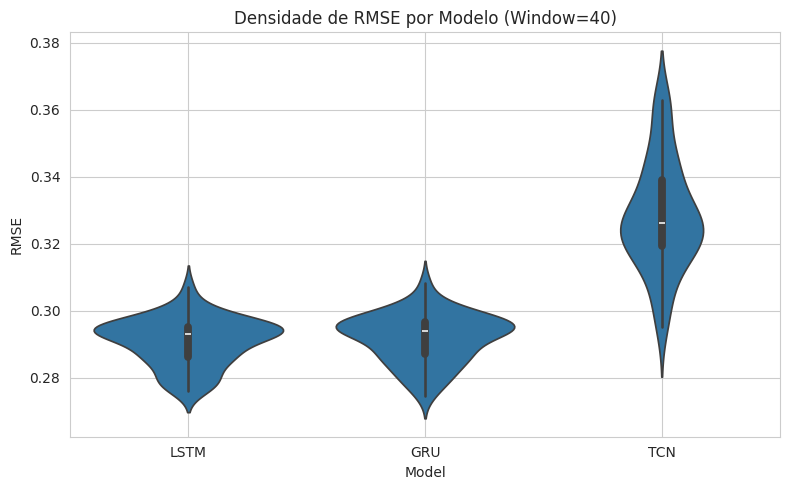

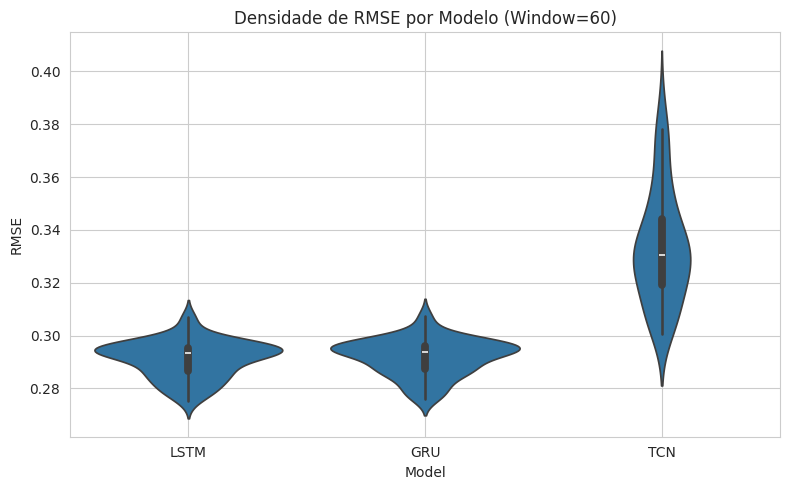

In [35]:
# Violinplot de RMSE por modelo e janela
for window in sorted(df_all['Window'].unique()):
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df_all[df_all['Window'] == window], x='Model', y='RMSE')
    plt.title(f'Densidade de RMSE por Modelo (Window={window})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Ranking médio por RMSE:
   Window Model      RMSE  Rank
1      20  LSTM  0.291125   1.0
0      20   GRU  0.291727   2.0
2      20   TCN  0.324996   3.0
4      40  LSTM  0.290880   1.0
3      40   GRU  0.291855   2.0
5      40   TCN  0.328239   3.0
7      60  LSTM  0.291193   1.0
6      60   GRU  0.291949   2.0
8      60   TCN  0.333354   3.0


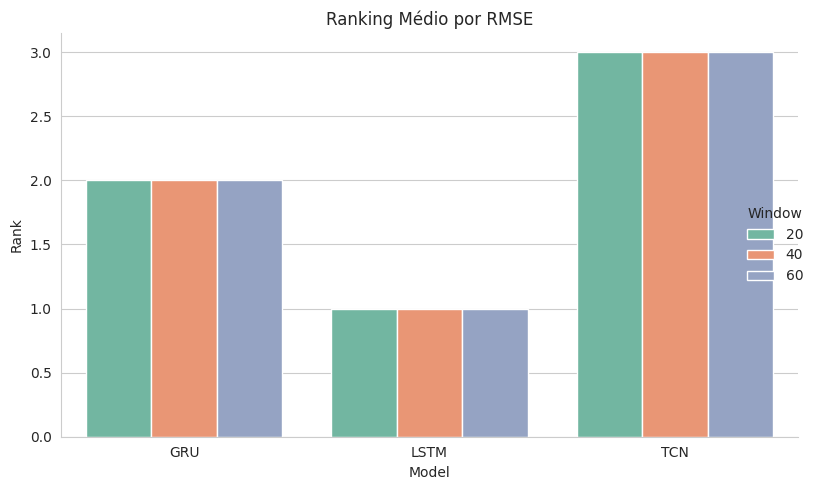

In [36]:
# ranking médio por RMSE (quanto menor melhor)
rank_rmse = df_all.groupby(['Window', 'Model'])['RMSE'].mean().reset_index()
rank_rmse['Rank'] = rank_rmse.groupby('Window')['RMSE'].rank(method='min')
print("\nRanking médio por RMSE:")
print(rank_rmse.sort_values(['Window', 'Rank']))

sns.catplot(data=rank_rmse, x='Model', y='Rank', hue='Window', kind='bar', height=5, aspect=1.5, palette='Set2')
plt.title("Ranking Médio por RMSE")
plt.tight_layout()
plt.show()

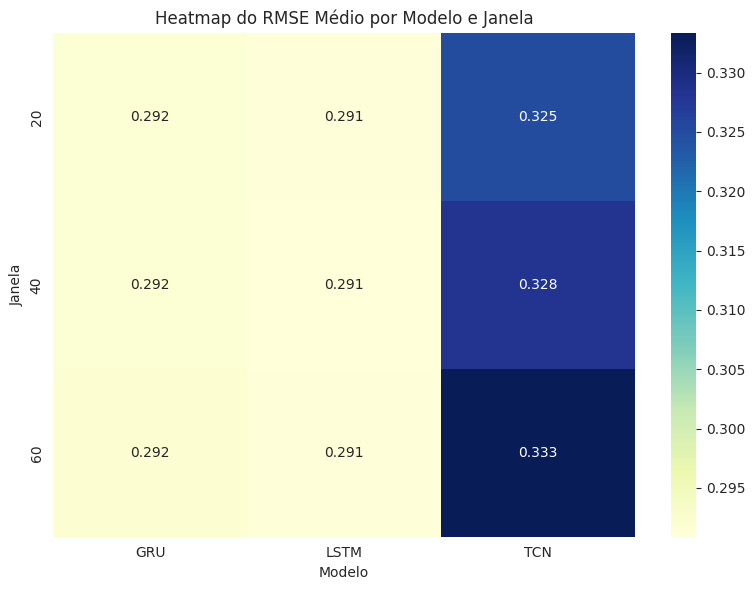

In [37]:
# heatmap do RMSE médio por modelo e janela
pivot_rmse = df_all.groupby(['Window', 'Model'])['RMSE'].mean().unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap do RMSE Médio por Modelo e Janela")
plt.ylabel("Janela")
plt.xlabel("Modelo")
plt.tight_layout()
plt.show()

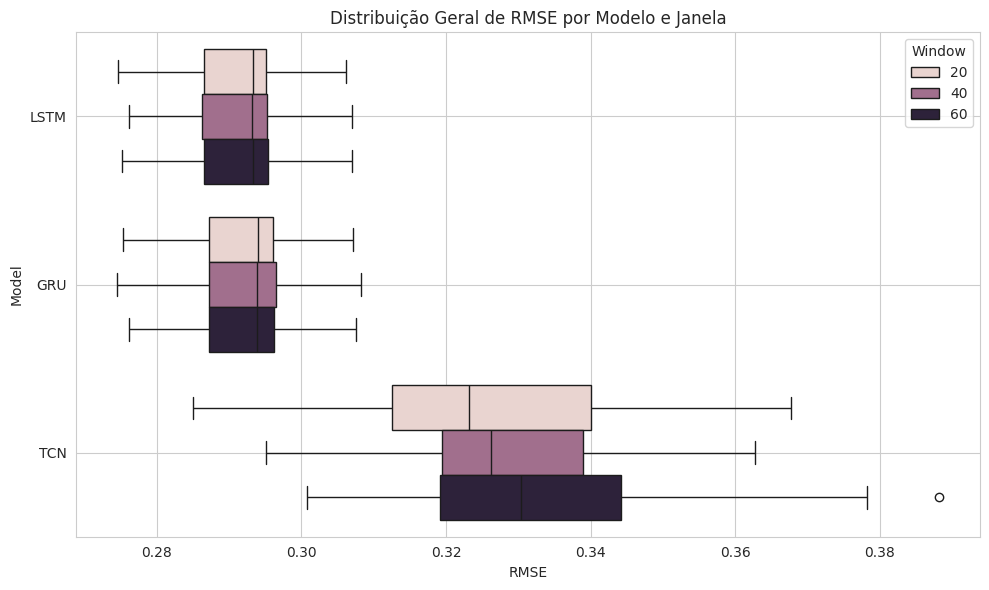

In [38]:
# boxplot geral de RMSE por modelo e janela
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='RMSE', y='Model', hue='Window', orient='h')
plt.title("Distribuição Geral de RMSE por Modelo e Janela")
plt.grid(True)
plt.tight_layout()
plt.show()

### ARIMA e SARIMA

In [42]:
arima_url = 'https://raw.githubusercontent.com/marcelowf/LineNex.Dataset/main/melhores_modelos_finais_arima_sarima.csv'
df_arima = pd.read_csv(arima_url)

# tabela de desempenho
summary_scores = df_arima.groupby('Best_Model')[['AIC', 'BIC', 'MSE']].mean().reset_index()
print("Resumo das métricas médias por modelo:")
print(summary_scores)
print("\n Em média, o modelo ARIMA possui MSE consideravelmente maior, indicando grande variação (ou outliers).\n")

# contagem total por modelo
model_counts = df_arima['Best_Model'].value_counts().reset_index()
model_counts.columns = ['Modelo', 'Quantidade']
print("Distribuição dos modelos mais selecionados:")
print(model_counts)
print("\n O modelo mais escolhido foi SARIMA com", model_counts.loc[0, 'Quantidade'], "ocorrências.\n")

# contagem por variável
sarima_vars = df_arima[df_arima['Best_Model'] == 'SARIMA']['Variable'].value_counts().reset_index()
sarima_vars.columns = ['Variável', 'SARIMA_Count']

arima_vars = df_arima[df_arima['Best_Model'] == 'ARIMA']['Variable'].value_counts().reset_index()
arima_vars.columns = ['Variável', 'ARIMA_Count']

# merge de contagens
merged_counts = pd.merge(arima_vars, sarima_vars, on='Variável', how='outer').fillna(0)
merged_counts[['ARIMA_Count', 'SARIMA_Count']] = merged_counts[['ARIMA_Count', 'SARIMA_Count']].astype(int)

print("Tabela resumo das variáveis mais associadas a cada modelo:")
print(merged_counts)

print("\nPrincipais associações modelo-variável:")
top_arima = merged_counts.sort_values('ARIMA_Count', ascending=False).iloc[0]
top_sarima = merged_counts.sort_values('SARIMA_Count', ascending=False).iloc[0]
print(f" - Variável mais modelada com ARIMA: {top_arima['Variável']} ({top_arima['ARIMA_Count']} vezes)")
print(f" - Variável mais modelada com SARIMA: {top_sarima['Variável']} ({top_sarima['SARIMA_Count']} vezes)\n")

Resumo das métricas médias por modelo:
  Best_Model           AIC           BIC           MSE
0      ARIMA   1486.832642   1509.501827  4.132334e+11
1     SARIMA  15189.002479  15220.853822  6.214493e+03

 Em média, o modelo ARIMA possui MSE consideravelmente maior, indicando grande variação (ou outliers).

Distribuição dos modelos mais selecionados:
   Modelo  Quantidade
0  SARIMA         147
1   ARIMA         103

 O modelo mais escolhido foi SARIMA com 147 ocorrências.

Tabela resumo das variáveis mais associadas a cada modelo:
                        Variável  ARIMA_Count  SARIMA_Count
0              Efficiency_Status           49             1
1                   Error_Rate_%            2            48
2   Predictive_Maintenance_Score           50             0
3  Production_Speed_units_per_hr            1            49
4  Quality_Control_Defect_Rate_%            1            49

Principais associações modelo-variável:
 - Variável mais modelada com ARIMA: Predictive_Maintenance_Sc

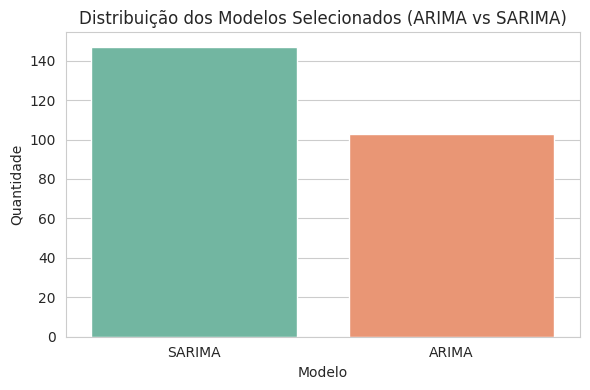

In [43]:
# gráfico de distribuição dos modelos selecionados
plt.figure(figsize=(6, 4))
sns.countplot(data=df_arima, x='Best_Model', hue='Best_Model', palette='Set2', legend=False)
plt.title("Distribuição dos Modelos Selecionados (ARIMA vs SARIMA)")
plt.xlabel("Modelo")
plt.ylabel("Quantidade")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

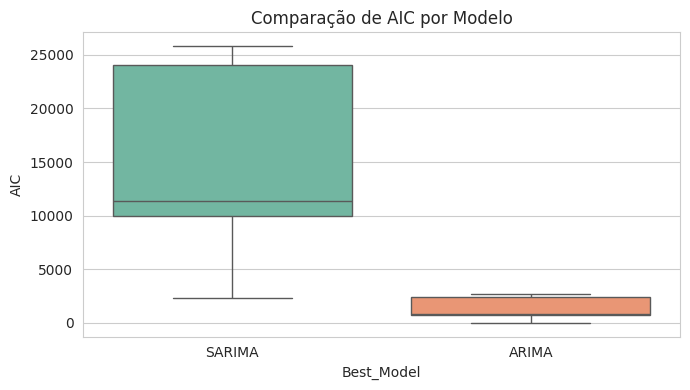

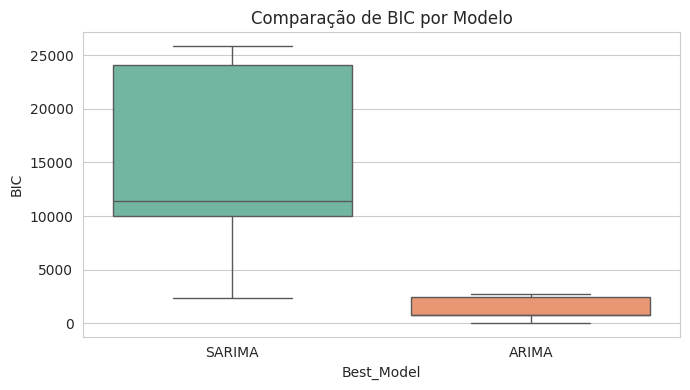

In [44]:
#  gráfico boxplot para AIC e BIC
for metric in ['AIC', 'BIC']:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df_arima, x='Best_Model', y=metric, hue='Best_Model', palette='Set2', legend=False)
    plt.title(f'Comparação de {metric} por Modelo')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

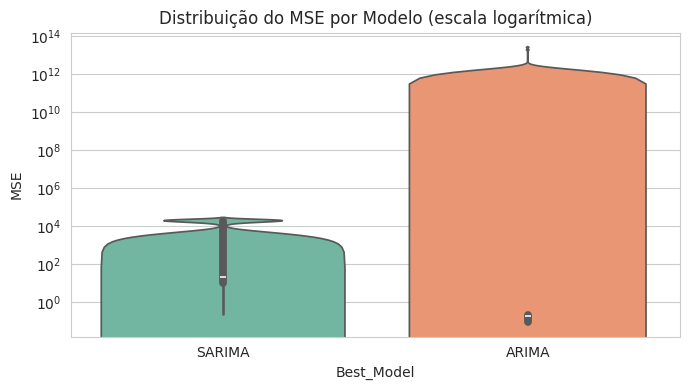

In [45]:
# gráfico MSE violin plot
plt.figure(figsize=(7, 4))
sns.violinplot(data=df_arima, x='Best_Model', y='MSE', hue='Best_Model', palette='Set2', legend=False)
plt.yscale('log')
plt.title('Distribuição do MSE por Modelo (escala logarítmica)')
plt.grid(True, axis='y', which='both')
plt.tight_layout()
plt.show()

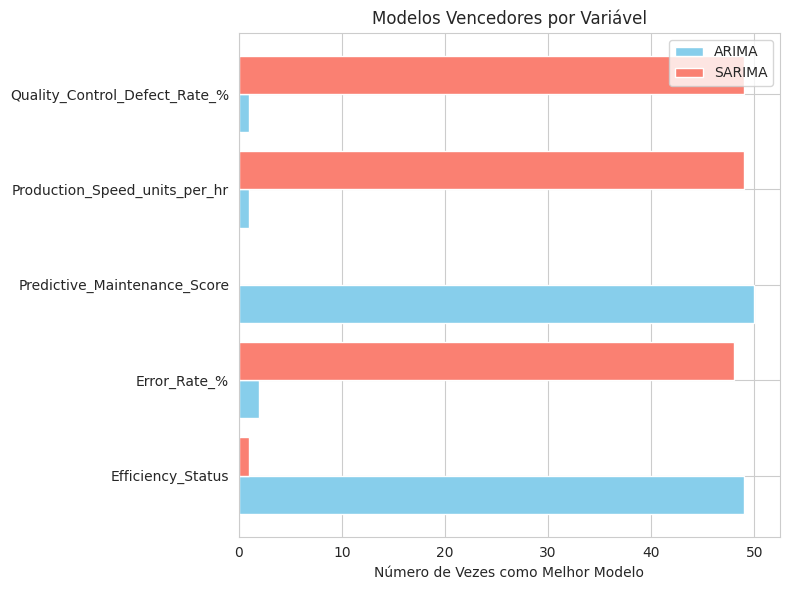

In [46]:
# gráfico de barras por variável
plt.figure(figsize=(8, 6))
merged_counts_sorted = merged_counts.sort_values('Variável')
bar_width = 0.4
index = range(len(merged_counts_sorted))

plt.barh(index, merged_counts_sorted['ARIMA_Count'], bar_width, label='ARIMA', color='skyblue')
plt.barh([i + bar_width for i in index], merged_counts_sorted['SARIMA_Count'], bar_width, label='SARIMA', color='salmon')

plt.yticks([i + bar_width / 2 for i in index], merged_counts_sorted['Variável'])
plt.xlabel('Número de Vezes como Melhor Modelo')
plt.title('Modelos Vencedores por Variável')
plt.legend()
plt.tight_layout()
plt.show()

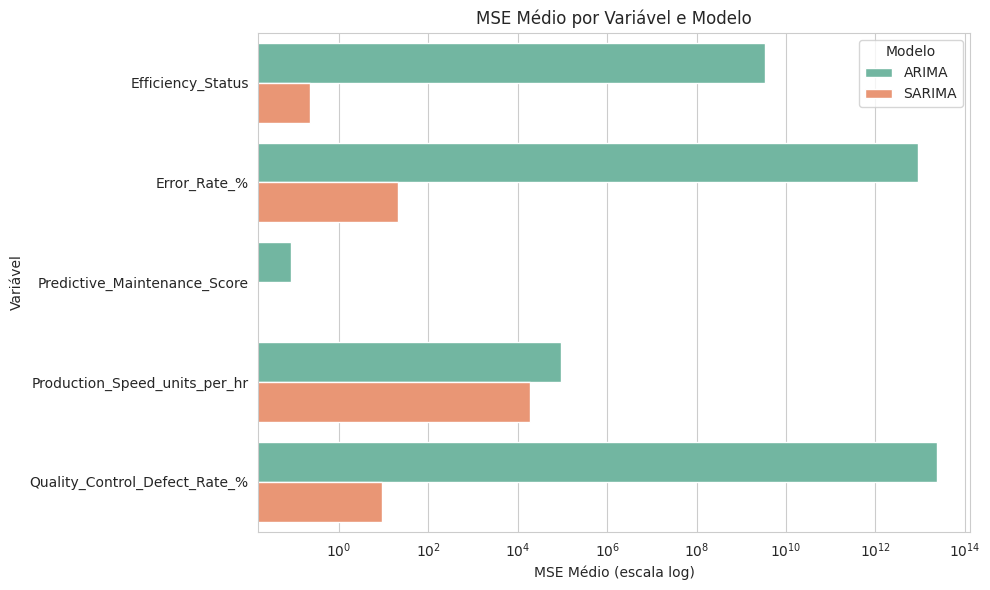

In [47]:
# gráfico MSE médio por variável e modelo
df_mse = df_arima.groupby(['Variable', 'Best_Model'])['MSE'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_mse, x='MSE', y='Variable', hue='Best_Model', palette='Set2')
plt.xscale('log')
plt.title("MSE Médio por Variável e Modelo")
plt.xlabel("MSE Médio (escala log)")
plt.ylabel("Variável")
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()

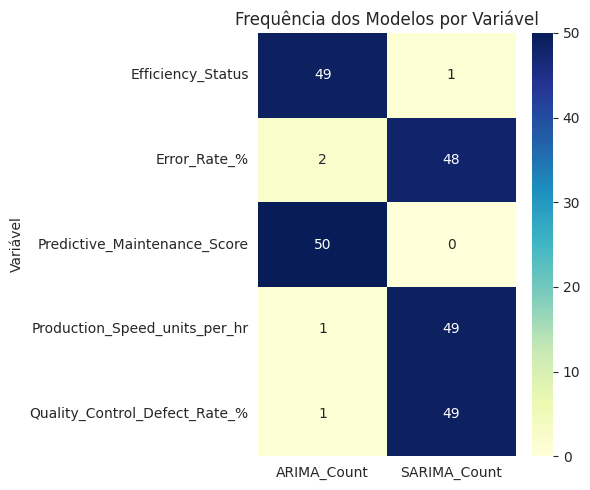

In [48]:
# mapa de calor ARIMA e SARIMA
heatmap_data = merged_counts.set_index('Variável')[['ARIMA_Count', 'SARIMA_Count']]
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Frequência dos Modelos por Variável")
plt.tight_layout()
plt.show()